# Когортный анализ конверсии из исполнительного листа в возбуждение исполнительного производства

#### Главная цель данного анализа - оценить и визуализировать операционную эффективность процесса взыскания, проанализировав временной лаг между получением юридического основания для взыскания (исполнительного листа) и фактическим началом работы приставов (возбуждением ИП - исполнительного производства).

Мы сможем ответить на вопрос: 'Насколько быстро и успешно исполнительный лист (ИЛ) превращается в работающий механизм взыскания?'

Ключевые вопросы:
- Сколько в среднем времени проходит от получения ИЛ до возбуждения ИП?
- Какой процент дел, по которым мы получили ИЛ, в итоге доходит до стадии возбужденного ИП? 
- Зависит ли скорость и успешность процесса от того, в каком месяце мы получили ИЛ? Стали ли мы работать быстрее/медленнее к концу года? 

В анализе используются две ключевые метрики:
- Конверсия в ВИП (возбуждение исполнительного производства)
- Время до ВИП

Для анализа мы будем использовать понятие 'месяц жизни' когорты, где месяц 0 - это месяц получения исполнительного листа, месяц 1 - следующий за ним календарный месяц, и так далее.

In [ ]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import os
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Задаем имя папки для сохранения изображений
IMAGE_DIR = '../images'

In [3]:
# Файл с мероприятиями по судебным делам
activities = pd.read_csv('../data/activities.csv')

# Приведем типы данных
activities['activity_date'] = pd.to_datetime(activities['activity_date'], format = '%Y-%m-%d')
activities['activity_type'] = activities['activity_type'].str.strip()
activities['employee'] = activities['employee'].str.strip()

# Нас интересуют данные за 2024 год
activities_filter = activities.loc[(activities['activity_date'] >= '2024-01-01') & (activities['activity_date'] <= '2024-12-31')]

In [4]:
# Находим дату получения ИЛ для каждого судебного дела (СД)
cohort = activities_filter.loc[activities_filter['activity_type'] == 'Получен исполнительный лист']
cohort_start = cohort.groupby('case_id').agg(start_date=('activity_date', 'max')).reset_index()
# Выведем периоды события
cohort_start['start_period'] = cohort_start['start_date'].dt.to_period('M').dt.to_timestamp()

# ВИП - возбуждено исполнительное производство, также находим дату этого события 
vip = activities_filter.loc[activities_filter['activity_type'] == 'Возбуждено исполнительное производство']
cohort_end = vip.groupby('case_id').agg(vip_date=('activity_date', 'max')).reset_index()
# Выведем периоды события
cohort_end['vip_period'] = cohort_end['vip_date'].dt.to_period('M').dt.to_timestamp()

## Распределение количества полученных ИЛ по месяцам 2024 года

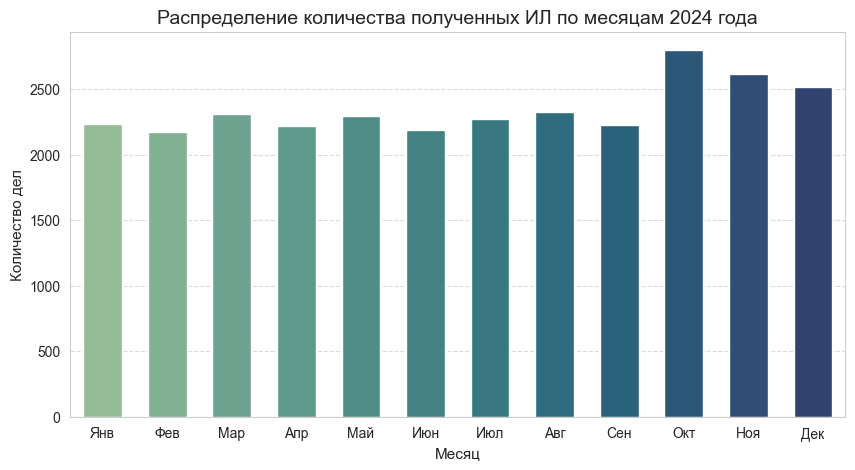

,start_period,case_id
0,2024-01-01,2231
1,2024-02-01,2171
2,2024-03-01,2310
3,2024-04-01,2221
4,2024-05-01,2293
5,2024-06-01,2190
6,2024-07-01,2269
7,2024-08-01,2322
8,2024-09-01,2226
9,2024-10-01,2797


In [5]:
# Посмотрим на кол-во полученных ИЛ по месяцам
month_distribution_IL = cohort_start.groupby('start_period')['case_id'].count().reset_index()

# Визуализация распределения
plt.figure(figsize=(10, 5))
sns.barplot(
    x='start_period',    
    y='case_id',             
    data=month_distribution_IL, 
    palette='crest',
    width=0.6
)

plt.title('Распределение количества полученных ИЛ по месяцам 2024 года', fontsize=14)
plt.xlabel('Месяц', fontsize=11)
plt.ylabel('Количество дел', fontsize=11)
plt.xticks(ticks=range(12), labels=['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Распределение количества полученных ИЛ по месяцам 2024 года.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()
month_distribution_IL

Анализ полученных исполнительных листов в 2024 году выявил ярко выраженную сезонность с пиком активности в 4-м квартале. Если в течение первых трех кварталов поступление дел было стабильным и колебалось в районе 2200 дел в месяц, то в октябре наблюдается резкий рост до 2800 дел - классическое 'закрытие года'.

## Распределение количества ВИП по месяцам 2024 года

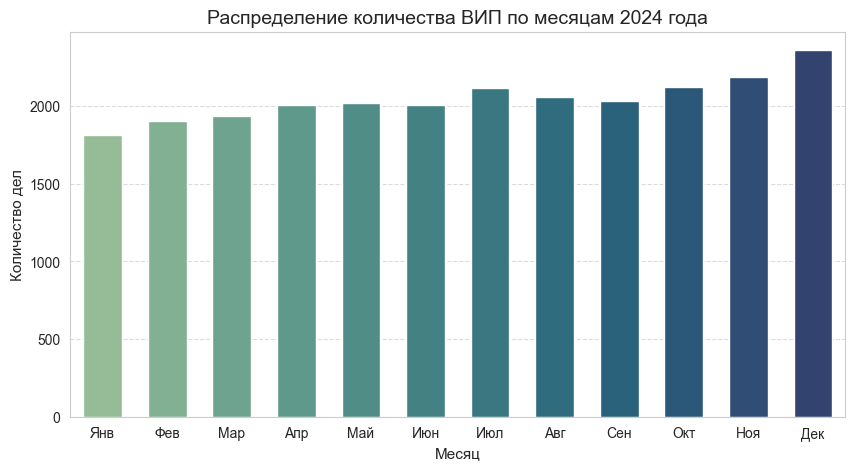

,vip_period,case_id
0,2024-01-01,1814
1,2024-02-01,1905
2,2024-03-01,1937
3,2024-04-01,2010
4,2024-05-01,2019
5,2024-06-01,2009
6,2024-07-01,2117
7,2024-08-01,2058
8,2024-09-01,2035
9,2024-10-01,2125


In [6]:
# Посмотрим на кол-во ВИП по месяцам
month_distribution_vip = cohort_end.groupby('vip_period')['case_id'].count().reset_index()

# Визуализация распределения
plt.figure(figsize=(10, 5))
sns.barplot(
    x='vip_period',    
    y='case_id',             
    data=month_distribution_vip, 
    palette='crest',
    width=0.6
)

plt.title('Распределение количества ВИП по месяцам 2024 года', fontsize=14)
plt.xlabel('Месяц', fontsize=11)
plt.ylabel('Количество дел', fontsize=11)
plt.xticks(ticks=range(12), labels=['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Распределение количества ВИП по месяцам 2024 года.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

month_distribution_vip

Нарастающая динамика в течение года:

В отличие от графика получения ИЛ, здесь мы видим более плавный, но уверенный тренд на рост количества ВИП в течение всего года. Если в январе-феврале возбуждается около 1800-1900 производств, то к концу года эта цифра достигает пика в декабре - более 2300.

Глядя на этот график, невозможно ответить на ключевые вопросы:

ВИП, возбужденные в марте, - это результат работы над 'быстрыми' февральскими делами или над 'медленными' январскими?
Высокие показатели в декабре - это заслуга эффективной обработки ноябрьских ИЛ или это наконец-то 'доехали' дела, полученные еще в октябре?

Таким образом, анализ общих месячных объемов по ВИП показывает нам, что происходит рост активности, но не объясняет 'как' и 'почему'. 
Чтобы понять истинную скорость и эффективность нашего процесса, необходимо перейти к когортному анализу. Именно он позволит нам 'проследить судьбу' каждой группы дел (каждой когорты) и точно измерить, сколько времени проходит от получения ИЛ до возбуждения ИП.

## Тепловая карта календарных когорт

#### В данном анализе когорта - это группа судебных дел (case_id), объединенных по месяцу получения ИЛ

In [7]:
# Присоединяем все полученные выше даты получения ИЛ и ВИП к СД
merged_data = pd.merge(cohort_start, cohort_end, how='left', on='case_id')
merged_data.head(5)

,case_id,start_date,start_period,vip_date,vip_period
0,1,2024-07-30,2024-07-01,2024-11-25,2024-11-01
1,3,2024-02-08,2024-02-01,2024-04-06,2024-04-01
2,4,2024-01-14,2024-01-01,2024-04-07,2024-04-01
3,5,2024-09-14,2024-09-01,2024-11-24,2024-11-01
4,6,2024-08-16,2024-08-01,2024-12-11,2024-12-01


In [8]:
# Сводная таблица, где строки - это месяц получения ИЛ, столбцы - месяц ВИП, значения - кол-во дел
calendar_cohort = pd.pivot_table(merged_data, index='start_period', columns='vip_period', values='case_id', aggfunc='count').fillna(0).astype(int)
# Преобразуем индекс (строки) из Timestamp в строки 'ГГГГ-ММ'
calendar_cohort.index = calendar_cohort.index.strftime('%Y-%m')
calendar_cohort.columns = calendar_cohort.columns.strftime('%Y-%m')
calendar_cohort

vip_period,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
start_period,,,,,,,,,,,,
2024-01,79,476,835,364,149,19,18,13,16,20,23,19
2024-02,0,56,493,845,339,143,17,16,23,19,15,8
2024-03,0,0,67,527,895,346,165,16,9,18,15,17
2024-04,0,0,0,90,511,842,373,138,12,15,20,13
2024-05,0,0,0,0,83,554,913,337,123,12,20,15
2024-06,0,0,0,0,0,63,506,847,359,120,12,11
2024-07,0,0,0,0,0,0,82,556,848,360,146,15
2024-08,0,0,0,0,0,0,0,82,520,865,365,157
2024-09,0,0,0,0,0,0,0,0,73,537,801,336


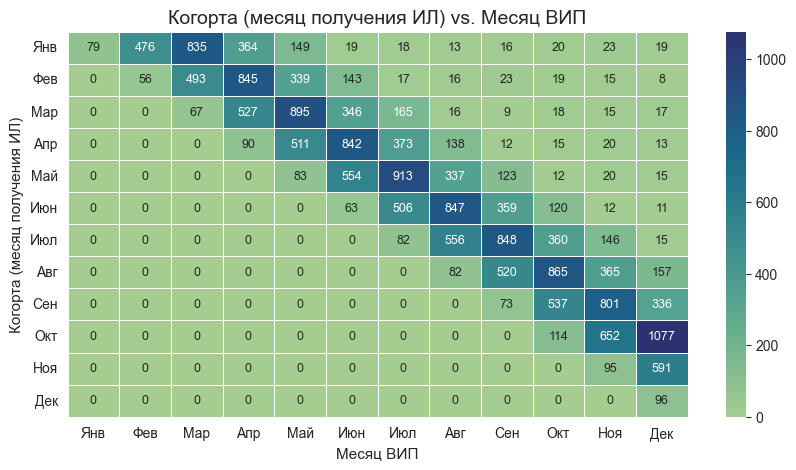

In [9]:
plt.figure(figsize=(10, 5)) 

# Создаем тепловую карту 
sns.heatmap(
    calendar_cohort, 
    annot=True,     
    fmt='d',        
    cmap="crest", 
    linewidths=.5, 
    annot_kws={'size': 9} 
)

# Добавляем заголовок и подписи
plt.title('Когорта (месяц получения ИЛ) vs. Месяц ВИП', fontsize=14)
plt.xlabel('Месяц ВИП', fontsize=11)
plt.ylabel('Когорта (месяц получения ИЛ)', fontsize=11)

months_labels = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
tick_locations = np.arange(len(months_labels)) + 0.5 

plt.yticks(
    ticks=tick_locations, 
    labels=months_labels, 
)

plt.xticks(
    ticks=tick_locations, 
    labels=months_labels, 
)

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Когорта (месяц получения ИЛ) vs. Месяц ВИП.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

Самые 'горячие' ячейки на карте формируют четкую диагональную полосу, смещенную вправо от главной диагонали. Это наглядно демонстрирует, что основная масса дел конвертируется в ВИП не в тот же месяц, когда был получен ИЛ, а в течение 1-2 последующих месяцев.

Например: Для январской когорты пик ВИП приходится на март (835 дел). Этот паттерн стабилен в течение всего года.

**Конверсия в 'месяц-в-месяц' минимальна:**

Ячейки на главной диагонали имеют относительно небольшие значения. Это подтверждает, что успеть провести дело по всему конвейеру в течение одного календарного месяца - скорее исключение, чем правило.

**Наличие 'длинного хвоста' конверсии:**

Хотя основная масса дел конвертируется быстро, для каждой когорты мы видим ненулевые значения в ячейках, отстоящих далеко вправо. Например, для январской когорты даже в декабре было возбуждено 19 производств. Это связано с исправлением ошибок в документах, сложными случаями или низкой эффективностью работы по отдельным делам. Анализ этих хвостов может стать темой для отдельного, более глубокого исследования.

**Стабильность процесса в течение года:**

Общий паттерн сохраняется для всех когорт с января по декабрь. Это говорит о том, что сам процесс и его средняя продолжительность стабильны и не претерпевают кардинальных изменений в течение года. Зная, сколько ИЛ мы получили в текущем месяце, мы можем с высокой точностью спрогнозировать, сколько ВИП будет возбуждено через 1, 2 и 3 месяца.

## Помесячная конверсия в процентах от размера когорты

Формула: (Количество возбужденных ИП / Количество полученных ИЛ за месяц) * 100%

In [10]:
# Размер когорты - общее кол-во полученных ИЛ в месяц
month_distribution_IL.rename(columns={'case_id': 'total_case_id'}, inplace=True)

# Найдем конверсию в процентах
monthly_percentage_values = calendar_cohort.values / month_distribution_IL['total_case_id'].values[:, np.newaxis] * 100

# Обернем его обратно в DataFrame, сохранив исходные индексы и колонки
monthly_percentage = pd.DataFrame(
    monthly_percentage_values,
    index=calendar_cohort.index,
    columns=calendar_cohort.columns
)
monthly_percentage = monthly_percentage.round(1)

monthly_percentage

vip_period,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
start_period,,,,,,,,,,,,
2024-01,3.5,21.3,37.4,16.3,6.7,0.9,0.8,0.6,0.7,0.9,1.0,0.9
2024-02,0.0,2.6,22.7,38.9,15.6,6.6,0.8,0.7,1.1,0.9,0.7,0.4
2024-03,0.0,0.0,2.9,22.8,38.7,15.0,7.1,0.7,0.4,0.8,0.6,0.7
2024-04,0.0,0.0,0.0,4.1,23.0,37.9,16.8,6.2,0.5,0.7,0.9,0.6
2024-05,0.0,0.0,0.0,0.0,3.6,24.2,39.8,14.7,5.4,0.5,0.9,0.7
2024-06,0.0,0.0,0.0,0.0,0.0,2.9,23.1,38.7,16.4,5.5,0.5,0.5
2024-07,0.0,0.0,0.0,0.0,0.0,0.0,3.6,24.5,37.4,15.9,6.4,0.7
2024-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,22.4,37.3,15.7,6.8
2024-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,24.1,36.0,15.1


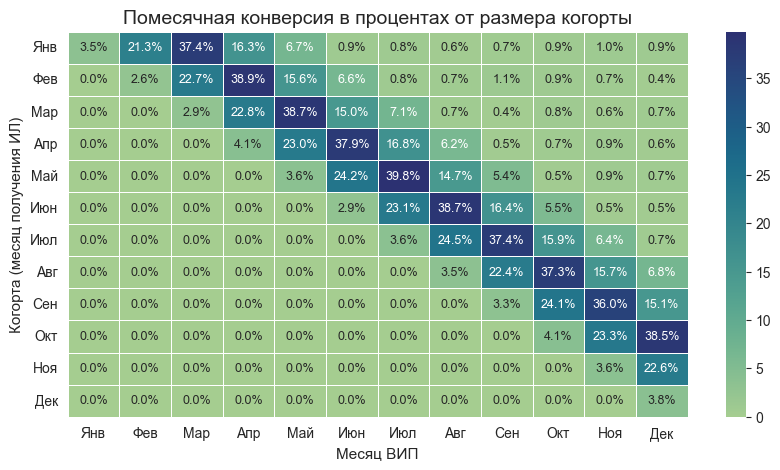

In [11]:
plt.figure(figsize=(10, 5)) 

# Применяем форматирование к каждой ячейке, превращая число в строку и добавляя '%'
# f'{x:.1f}%' - это f-строка, которая форматирует число x с 1 знаком после запятой и добавляет %
annotations = monthly_percentage.applymap(lambda x: f'{x:.1f}%')

# Создаем тепловую карту 
sns.heatmap(
    monthly_percentage, 
    annot=annotations,     
    fmt='',        
    cmap='crest', 
    linewidths=.5, 
    annot_kws={'size': 9} 
)

# Добавляем заголовок и подписи
plt.title('Помесячная конверсия в процентах от размера когорты', fontsize=14)
plt.xlabel('Месяц ВИП', fontsize=11)
plt.ylabel('Когорта (месяц получения ИЛ)', fontsize=11)

months_labels = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
tick_locations = np.arange(len(months_labels)) + 0.5 

plt.yticks(
    ticks=tick_locations, 
    labels=months_labels, 
)

plt.xticks(
    ticks=tick_locations, 
    labels=months_labels, 
)

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Помесячная конверсия в процентах от размера когорты.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

Пиковая месячная конверсия для большинства когорт колеблется в районе 36-40%.

## Куммулятивная конверсия

In [12]:
# Расчет куммулятивной суммы по месяцам 
# axis=1 - считаем сумму по строкам (слева направо)
cumulative_absolute = calendar_cohort.cumsum(axis=1)

cumulative_absolute

vip_period,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
start_period,,,,,,,,,,,,
2024-01,79,555,1390,1754,1903,1922,1940,1953,1969,1989,2012,2031
2024-02,0,56,549,1394,1733,1876,1893,1909,1932,1951,1966,1974
2024-03,0,0,67,594,1489,1835,2000,2016,2025,2043,2058,2075
2024-04,0,0,0,90,601,1443,1816,1954,1966,1981,2001,2014
2024-05,0,0,0,0,83,637,1550,1887,2010,2022,2042,2057
2024-06,0,0,0,0,0,63,569,1416,1775,1895,1907,1918
2024-07,0,0,0,0,0,0,82,638,1486,1846,1992,2007
2024-08,0,0,0,0,0,0,0,82,602,1467,1832,1989
2024-09,0,0,0,0,0,0,0,0,73,610,1411,1747


In [13]:
# Найдем куммулятивную конверсию в процентах
cumulative_percentage_values = cumulative_absolute.values / month_distribution_IL['total_case_id'].values[:, np.newaxis] * 100

# Обернем его обратно в DataFrame, сохранив исходные индексы и колонки
cumulative_percentage = pd.DataFrame(
    cumulative_percentage_values,
    index=cumulative_absolute.index,
    columns=cumulative_absolute.columns
)
cumulative_percentage = cumulative_percentage.round(1)

cumulative_percentage

vip_period,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
start_period,,,,,,,,,,,,
2024-01,3.5,24.9,62.3,78.6,85.3,86.1,87.0,87.5,88.3,89.2,90.2,91.0
2024-02,0.0,2.6,25.3,64.2,79.8,86.4,87.2,87.9,89.0,89.9,90.6,90.9
2024-03,0.0,0.0,2.9,25.7,64.5,79.4,86.6,87.3,87.7,88.4,89.1,89.8
2024-04,0.0,0.0,0.0,4.1,27.1,65.0,81.8,88.0,88.5,89.2,90.1,90.7
2024-05,0.0,0.0,0.0,0.0,3.6,27.8,67.6,82.3,87.7,88.2,89.1,89.7
2024-06,0.0,0.0,0.0,0.0,0.0,2.9,26.0,64.7,81.1,86.5,87.1,87.6
2024-07,0.0,0.0,0.0,0.0,0.0,0.0,3.6,28.1,65.5,81.4,87.8,88.5
2024-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,25.9,63.2,78.9,85.7
2024-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,27.4,63.4,78.5


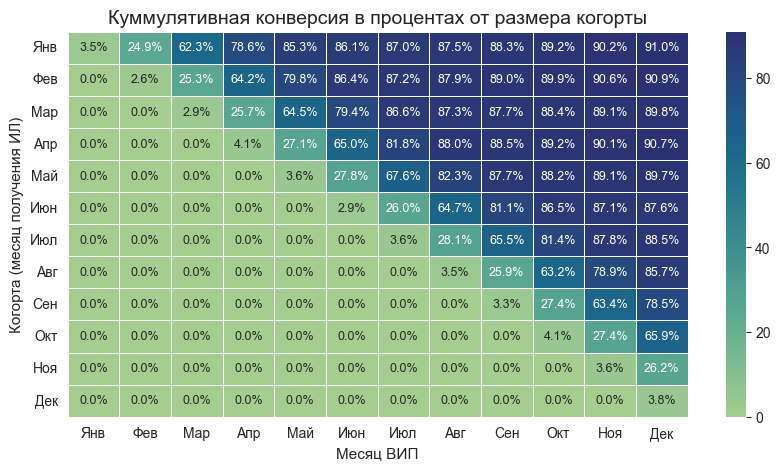

In [14]:
plt.figure(figsize=(10, 5)) 

# Применяем форматирование к каждой ячейке, превращая число в строку и добавляя '%'
annotations = cumulative_percentage.applymap(lambda x: f'{x:.1f}%')

# Создаем тепловую карту 
sns.heatmap(
    cumulative_percentage,
    annot=annotations,     
    fmt='',        
    cmap='crest', 
    linewidths=.5, 
    annot_kws={'size': 9} 
)

# Добавляем заголовок и подписи
plt.title('Куммулятивная конверсия в процентах от размера когорты', fontsize=14)
plt.xlabel('Месяц ВИП', fontsize=11)
plt.ylabel('Когорта (месяц получения ИЛ)', fontsize=11)

months_labels = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
tick_locations = np.arange(len(months_labels)) + 0.5 

plt.yticks(
    ticks=tick_locations, 
    labels=months_labels, 
)

plt.xticks(
    ticks=tick_locations, 
    labels=months_labels, 
)

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Куммулятивная конверсия в процентах от размера когорты.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

## Возрастной когортный отчет

Представим когортный отчет по 'месяцам жизни'

In [15]:
# Вычислим месяц жизни = месяц ВИП - месяц получения ИЛ
# Считаем месяц получения ИЛ нулевым месяцем, как указано в начале в описании 
life_time_cohort = merged_data.copy()
life_time_cohort['life_time'] = (
    (life_time_cohort['vip_period'].dt.year - life_time_cohort['start_period'].dt.year) * 12 +
    (life_time_cohort['vip_period'].dt.month - life_time_cohort['start_period'].dt.month)
)

life_time_cohort.head(3)

,case_id,start_date,start_period,vip_date,vip_period,life_time
0,1,2024-07-30,2024-07-01,2024-11-25,2024-11-01,4.0
1,3,2024-02-08,2024-02-01,2024-04-06,2024-04-01,2.0
2,4,2024-01-14,2024-01-01,2024-04-07,2024-04-01,3.0


In [16]:
# Сводная таблица, где строки - это месяц получения ИЛ, столбцы - месяц жизни, значения - кол-во дел
life_time_cohort_pivot = pd.pivot_table(life_time_cohort, index='start_period', columns='life_time', values='case_id', aggfunc='count').fillna(0).astype(int)
# Преобразуем индекс из Timestamp в строки 'ГГГГ-ММ'
life_time_cohort_pivot.index = life_time_cohort_pivot.index.strftime('%Y-%m')
# Преобразуем столбцы в тип int
life_time_cohort_pivot.columns = life_time_cohort_pivot.columns.astype('int')
# Заменяем 0 на '-' - месяцы жизни без данных. Кумулятивная сумма остановится на первом '-'
life_time_cohort_pivot = life_time_cohort_pivot.replace(0, '-')
life_time_cohort_pivot

life_time,0,1,2,3,4,5,6,7,8,9,10,11
start_period,,,,,,,,,,,,
2024-01,79,476,835,364,149,19,18,13,16,20,23,19
2024-02,56,493,845,339,143,17,16,23,19,15,8,-
2024-03,67,527,895,346,165,16,9,18,15,17,-,-
2024-04,90,511,842,373,138,12,15,20,13,-,-,-
2024-05,83,554,913,337,123,12,20,15,-,-,-,-
2024-06,63,506,847,359,120,12,11,-,-,-,-,-
2024-07,82,556,848,360,146,15,-,-,-,-,-,-
2024-08,82,520,865,365,157,-,-,-,-,-,-,-
2024-09,73,537,801,336,-,-,-,-,-,-,-,-


In [17]:
# Функция для вычисления куммулитивной суммы, остановимся на первом '-'
def cumulative_with_stop(row):
    result = []
    running_total = 0
    for val in row:
        if val == '-':
            result.append('-')
        else:
            running_total += int(val)
            result.append(running_total)
    return result

cumulative_life_time = life_time_cohort_pivot.apply(cumulative_with_stop, axis=1, result_type='expand')

In [18]:
# Определяем индекс в таблице с распределением полученных ИЛ по месяцам
month_distribution_IL = month_distribution_IL.set_index('start_period')

In [19]:
# Функция для вычисления процента конверсии
def calculate_life_time_percentage(cohort_pivot, month_distribution):
    result = []
    for idx, row in cohort_pivot.iterrows():
        total = month_distribution.loc[idx].item() 
        new_row = []
        for val in row:
            try:
                num = float(val)
                percent = num / total * 100
                new_row.append(percent)
            except (ValueError, TypeError):
                new_row.append(0.0)  # если '-'
        result.append(new_row)
    return pd.DataFrame(result, columns=cohort_pivot.columns, index=cohort_pivot.index)
life_time_cohort_values = calculate_life_time_percentage(cumulative_life_time, month_distribution_IL['total_case_id'])

# Обернем обратно в DataFrame, сохранив исходные индексы и колонки
cumulative_life_time_cohort = pd.DataFrame(
    life_time_cohort_values,
    index=cumulative_life_time.index,
    columns=cumulative_life_time.columns
)
cumulative_life_time_cohort = cumulative_life_time_cohort.round(1)

cumulative_life_time_cohort

,0,1,2,3,4,5,6,7,8,9,10,11
start_period,,,,,,,,,,,,
2024-01,3.5,24.9,62.3,78.6,85.3,86.1,87.0,87.5,88.3,89.2,90.2,91.0
2024-02,2.6,25.3,64.2,79.8,86.4,87.2,87.9,89.0,89.9,90.6,90.9,0.0
2024-03,2.9,25.7,64.5,79.4,86.6,87.3,87.7,88.4,89.1,89.8,0.0,0.0
2024-04,4.1,27.1,65.0,81.8,88.0,88.5,89.2,90.1,90.7,0.0,0.0,0.0
2024-05,3.6,27.8,67.6,82.3,87.7,88.2,89.1,89.7,0.0,0.0,0.0,0.0
2024-06,2.9,26.0,64.7,81.1,86.5,87.1,87.6,0.0,0.0,0.0,0.0,0.0
2024-07,3.6,28.1,65.5,81.4,87.8,88.5,0.0,0.0,0.0,0.0,0.0,0.0
2024-08,3.5,25.9,63.2,78.9,85.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-09,3.3,27.4,63.4,78.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


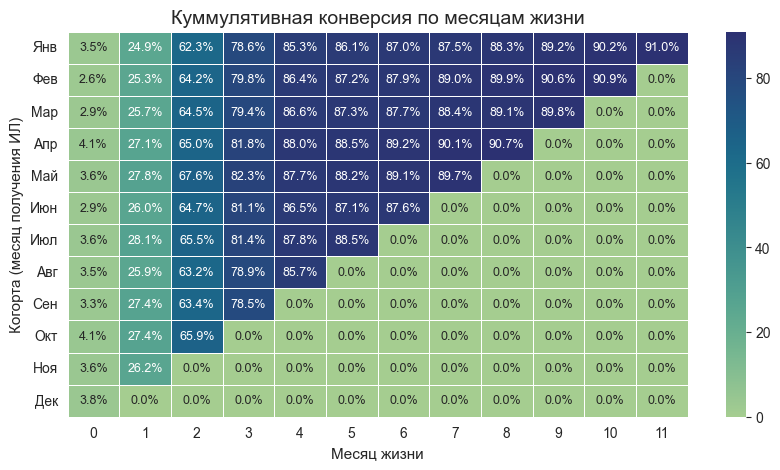

In [20]:
plt.figure(figsize=(10, 5)) 

# Применяем форматирование к каждой ячейке, превращая число в строку и добавляя '%'
annotations = cumulative_life_time_cohort.applymap(lambda x: f'{x:.1f}%')

# Создаем тепловую карту 
sns.heatmap(
    cumulative_life_time_cohort,
    annot=annotations,     
    fmt='',        
    cmap='crest', 
    linewidths=.5, 
    annot_kws={'size': 9} 
)

# Добавляем заголовок и подписи
plt.title('Куммулятивная конверсия по месяцам жизни', fontsize=14)
plt.xlabel('Месяц жизни', fontsize=11)
plt.ylabel('Когорта (месяц получения ИЛ)', fontsize=11)

months_labels = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
tick_locations = np.arange(len(months_labels)) + 0.5 

plt.yticks(
    ticks=tick_locations, 
    labels=months_labels, 
)

plt.xticks(
    ticks=tick_locations
)

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Куммулятивная конверсия по месяцам жизни.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

Для всех когорт наблюдается схожая динамика: активный рост конверсии в течение первых пяти месяцев (с месяца 0 по месяц 4) после получения ИЛ, после этого рост конверсии значительно замедляется, и процесс выходит на плато с итоговым показателем конверсии около 90-91%.

При более детальном сравнении когорт между собой, апрельская и майская когорты демонстрируют наилучшие показатели скорости конверсии. На каждом этапе своего жизненного цикла они опережают соседние когорты на 1-3 процентных пункта, достигая итоговой конверсии в 90% к концу года.

## Куммулятивная конверсия в ВИП по месяцам жизни когорты на линейном графике

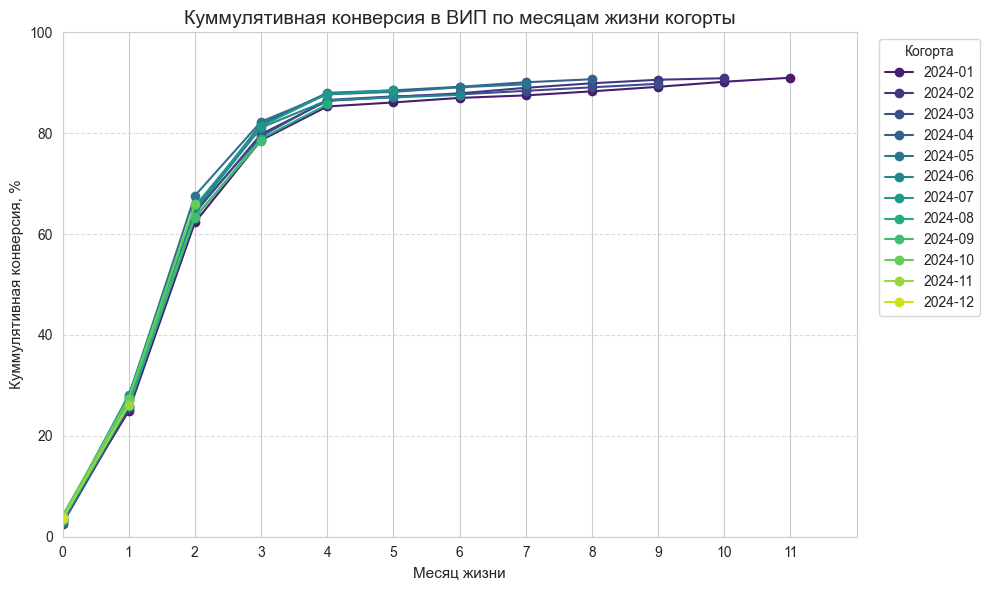

In [21]:
plot_data = cumulative_life_time_cohort.replace(0.0, np.nan)

plt.figure(figsize=(10, 6))
ax = plt.gca()

palette = sns.color_palette('viridis', n_colors=len(plot_data))

for i, cohort_name in enumerate(plot_data.index):
    cohort_data = plot_data.loc[cohort_name]
    plot_points = cohort_data.dropna()
    
    if not plot_points.empty:
        ax.plot(
            plot_points.index,
            plot_points.values,
            marker='o',
            linestyle='-',
            color=palette[i],
            label=cohort_name.strftime('%Y-%m') if isinstance(cohort_name, pd.Timestamp) else str(cohort_name)
        )

ax.set_title('Куммулятивная конверсия в ВИП по месяцам жизни когорты', fontsize=14)
ax.set_xlabel('Месяц жизни', fontsize=11)
ax.set_ylabel('Куммулятивная конверсия, %', fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Создаем метки на основе названий колонок в исходной таблице
x_labels = cumulative_life_time_cohort.columns
ax.set_xticks(ticks=np.arange(len(x_labels)), labels=x_labels)

# Создаем легенду
ax.legend(title='Когорта', bbox_to_anchor=(1.02, 1), loc='upper left')

# Устанавливаем лимиты
ax.set_xlim(0, len(x_labels))
ax.set_ylim(0, 100)

plt.tight_layout()

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Куммулятивная конверсия в ВИП по месяцам жизни когорты.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

Можно заметить, что некоторые линии находятся чуть выше или ниже других. Например, темно-фиолетовая линия (январь) отстает от остальных в районе 2-3 месяца жизни. Эти различия минимальны и связаны с исправлением ошибок в документах, сложных случаях, которые являются допустимыми в судебном процессе.

## Медианное время до ВИП в днях

In [22]:
# Рассчитаем разницу между датой ВИП и датой получения ИЛ в днях
merged_data['diff'] = (merged_data['vip_date'] - merged_data['start_date']).dt.days
# Оставим  ненулевые значения
time_to_vip = merged_data.loc[merged_data['diff'].notna()]

print(('Медианное время в днях от даты получения исполнительного листа до даты возбуждения исполнительного производства - {}').
      format(time_to_vip['diff'].median().astype('int')))
print(('Среднее время в днях от даты получения исполнительного листа до даты возбуждения исполнительного производства - {}').
      format(time_to_vip['diff'].mean().astype('int')))

Медианное время в днях от даты получения исполнительного листа до даты возбуждения исполнительного производства - 53
Среднее время в днях от даты получения исполнительного листа до даты возбуждения исполнительного производства - 61


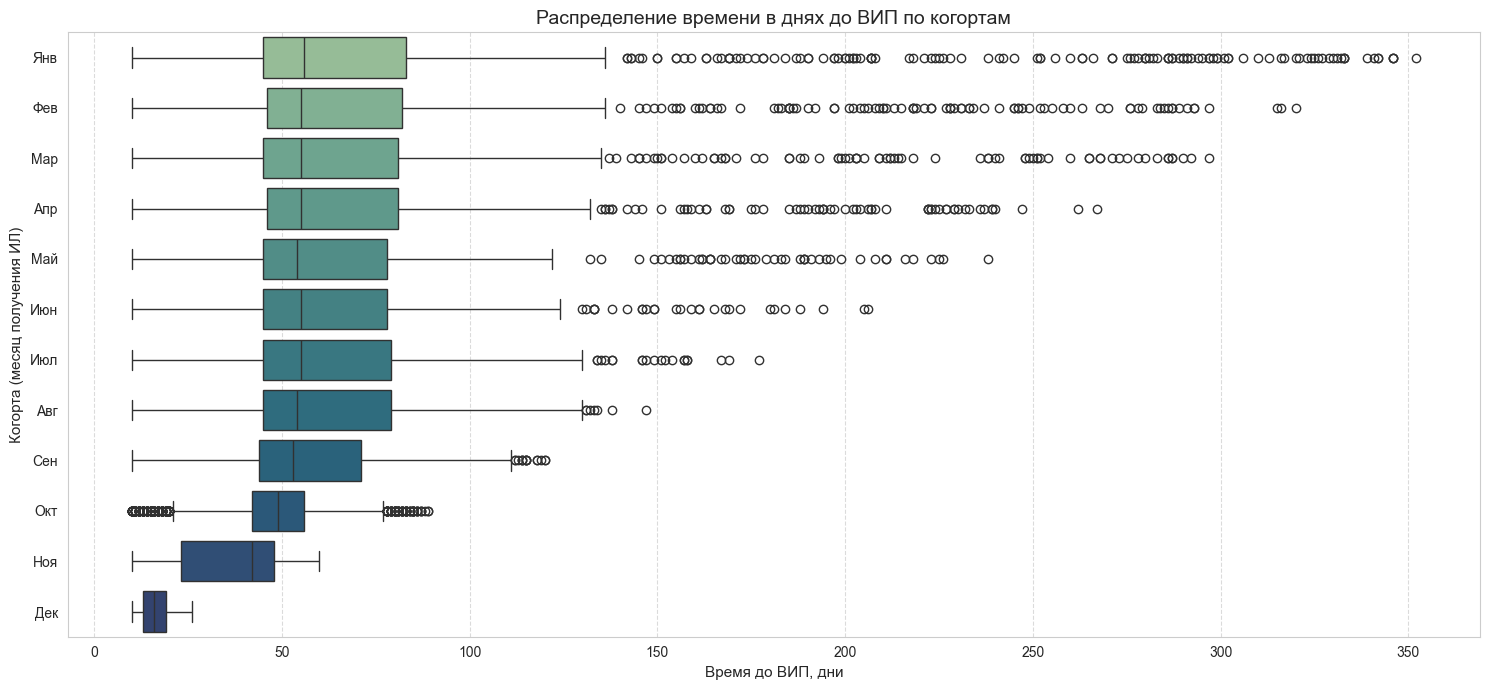

In [23]:
# Распределение времени до ВИП в днях
plt.figure(figsize=(15, 7))

time_to_vip = time_to_vip.sort_values('start_period')  # Сортировка по датам

sns.boxplot(
    data=time_to_vip,
    x='diff',  
    y='start_period',   
    palette='crest'  
)

plt.title('Распределение времени в днях до ВИП по когортам', fontsize=14)
plt.xlabel('Время до ВИП, дни', fontsize=11)
plt.ylabel('Когорта (месяц получения ИЛ)', fontsize=11)
plt.yticks(ticks=range(12), labels=['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Устанавливаем лимиты
ax.set_xlim(0, time_to_vip['diff'].max())

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Распределение времени в днях до ВИП по когортам.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

Ранние когорты имели в распоряжении больше месяцев для 'созревания', что позволило зафиксировать и долгие случаи ВИП. В то же время, для поздних когорт (например, ноябрьской) мы видим только самые быстрые ВИП, произошедшие до конца декабря. Их собственный 'длинный хвост' проявится уже в 2025 году и не попадает в данный анализ.

Вспоминаем распределение полученных ИЛ по месяцам, в 4 квартале наблюдается значительный рост получения ИЛ, с пиком в октябре. 
Именно этот пик в октябре (около 2800 дел - на 27% больше чем в предыдущие периоды) является первопричиной визуальной аномалии, которую мы наблюдаем на графике. Большое количество дел привело к увеличению абсолютного числа 'медленных' и 'быстрых' случаев, которые boxplot пометил как выбросы, визуально 'сжав' основное распределение. Тем не менее медианное время конверсии для октября остается на том же уровне, что и для других месяцев (~50 дней).

## Выводы

1. **Сколько в среднем времени проходит от получения ИЛ до возбуждения ИП?**

Основная масса дел (более 50%) успешно проходит процедуру за 53 дня. Среднее время составляет 61 день, что указывает на наличие 'длинного хвоста' - определенной доли дел, обработка которых по разным причинам затягивается. Как показал анализ, пик возбуждения производств для каждой когорты приходится на 1-2 месяц после получения ИЛ.

2. **Какой процент дел, по которым мы получили ИЛ, в итоге доходит до стадии возбужденного ИП?**

Процесс демонстрирует высокую и стабильную итоговую конверсию. 90-91% всех полученных исполнительных листов в конечном итоге успешно конвертируются в ВИП. Этот показатель остается стабильным для всех когорт, прошедших полный жизненный цикл. Оставшиеся 9-10% дел, не дошедших до ВИП, являются зоной для дальнейшего, более точечного анализа.

3. **Зависит ли скорость и успешность процесса от месяца получения ИЛ? Стали ли мы работать быстрее/медленнее к концу года?**

Процесс стабилен, однако наблюдаются незначительные колебания в эффективности. Когорты апреля и мая показали наилучшую динамику, опережая остальные на несколько процентных пунктов (1-3%) на ранних этапах. Несмотря на резкий рост нагрузки в 4-м квартале (увеличение послученных ИЛ), признаков замедления процесса не наблюдается. Конверсия для октябрьской когорты сопоставима с показателями предыдущих месяцев. 